In [3]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np


def create_data_loader(file_name='weather_data.csv', batch_size=1):
	# Load the CSV file
	df = pd.read_csv(file_name)  # Replace with your file path

	# Step 1: Extract nodes and edges
	nodes = df['node_id'].unique()
	node_to_idx = {node: idx for idx, node in enumerate(nodes)}  # Map node_id to 0-146
	n_nodes = len(nodes)  # 147

	# Parse edge_list to create edge_index
	edge_list = []
	for _, row in df.iterrows():
		source = node_to_idx[row['node_id']]
		targets = eval(row['edge_list'])  # Convert string "[1, 99, ...]" to list
		for target in targets:
			edge_list.append([source, node_to_idx[target]])

	edge_index = torch.tensor(edge_list, dtype=torch.long).t()  # Shape: [2, E]
	# Ensure undirected: add reverse edges
	edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
	# Remove duplicates
	edge_index = torch.unique(edge_index, dim=1, sorted=True)

	# Step 2: Define weather features and normalize
	weather_features = [
		'latitude', 'longitude',
		'temperature_max', 'temperature_min', 'temperature_mean',
		'precipitation_sum', 'snowfall_sum', 'relative_humidity_max',
		'relative_humidity_min', 'dewpoint_max', 'dewpoint_min'
	]

	# Compute mean and std across all data
	means = df[weather_features].mean()
	stds = df[weather_features].std()
	stds[stds == 0] = 1e-10  # Avoid division by zero

	def standardize(df_day):
		return (df_day[weather_features] - means) / stds

	# Step 3: Define edge labels
	def compute_edge_labels(df_day, edge_index):
		temp_min = df_day['temperature_min'].values
		precip = df_day['precipitation_sum'].values
		snow = df_day['snowfall_sum'].values
		labels = []
		for i in range(edge_index.size(1)):
			u, v = edge_index[:, i].tolist()
			min_temp = min(temp_min[u], temp_min[v])
			max_precip = max(precip[u], precip[v])
			max_snow = max(snow[u], snow[v])
			icy = min_temp < 0 and (max_precip > 0 or max_snow > 0)
			labels.append(1 if icy else 0)
		return torch.tensor(labels, dtype=torch.float)

	# Step 4: Create Data objects for each day
	dates = sorted(df['date'].unique())  # 8 unique dates
	data_list = []
	for date in dates:
		df_day = df[df['date'] == date].sort_values('node_id')  # Ensure consistent node order
		x = standardize(df_day).values  # Shape: [147, 9]
		# print(x)
		x = torch.tensor(x, dtype=torch.float)
		edge_labels = compute_edge_labels(df_day, edge_index)
		
		data = Data(
			x=x,
			edge_index=edge_index,
			edge_label_index=edge_index,  # Predict all edges
			edge_label=edge_labels
		)
		data_list.append(data)

	# Step 5: Create DataLoader
	loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)  # Batch size 1 for 8 days
	return loader



In [4]:

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

def visualize_graph(edge_index, edge_labels, title, pos=None):
    """
    Visualizes a graph with edges colored based on labels.
    
    Parameters:
    - edge_index: Tensor of shape [2, num_edges] representing graph edges.
    - edge_labels: Tensor of shape [num_edges] with binary labels (0 or 1).
    - title: Title of the plot (e.g., "Ground Truth Icy Roads").
    - pos: Optional; precomputed layout positions for consistency.
    
    Returns:
    - pos: The layout positions used for the graph.
    """
    # Create a NetworkX graph from edge_index
    G = nx.Graph()
    edges = edge_index.t().tolist()  # Convert edge_index to list of edge tuples
    G.add_edges_from(edges)
    
    # Assign colors to edges based on labels (red for icy, black for normal)
    colors = ['red' if label == 1 else 'black' for label in edge_labels]
    
    # Draw the graph with specified colors
    if pos is None:
        pos = nx.spring_layout(G)  # Compute layout if not provided
    nx.draw(G, pos, node_color='black', edge_color=colors, with_labels=False, 
            node_size=5, font_color='white', width=0.5)
    plt.title(title)
    plt.show()
    return pos

class GNNEdgePredictor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNEdgePredictor, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # GNN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # Edge prediction
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_pred = self.mlp(edge_features).squeeze()
        return torch.sigmoid(edge_pred)  # Probability of icy road
    

class CombinedGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CombinedGNN, self).__init__()
        # GCN layer
        self.gcn = GCNConv(input_dim, hidden_dim)
        # GAT layer with 4 attention heads
        self.gat = GATConv(hidden_dim, hidden_dim, heads=4, concat=True)
        # GraphSAGE layer (adjust input for GAT's concatenated output)
        self.sage = SAGEConv(hidden_dim * 4, hidden_dim)
        # MLP for edge prediction
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # GCN layer
        x = self.gcn(x, edge_index)
        x = F.relu(x)
        # GAT layer
        x = self.gat(x, edge_index)
        x = F.relu(x)
        # GraphSAGE layer
        x = self.sage(x, edge_index)
        x = F.relu(x)
        # Edge prediction: concatenate embeddings of edge endpoints
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_pred = self.mlp(edge_features).squeeze()
        return torch.sigmoid(edge_pred)



# Training loop
def train(model, loader, optimizer, criterion, epochs=1000):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        i = 0
        for data in loader:
            if i <= 3:
                optimizer.zero_grad()
                out = model(data)  # Edge predictions
                loss = criterion(out, data.edge_label)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            i += 1
        avg_loss = total_loss / 4#len(loader)
        losses.append(avg_loss)
        if (epoch + 1) % 50 == 0:
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

    return losses

def evaluate_model(model, loader):
	all_preds = []
	all_labels = []
	model.eval()
	i = 0
	with torch.no_grad():
		for data in loader:
			if i >=4:
			# Ground truth labels
				ground_truth_labels = data.edge_label  # Tensor of 0s and 1s
				pred = model(data)
				# print(pred)
				predicted_labels = (pred > 0.7).float()  # Threshold at 0.5
				# print("Predicted icy roads (edge labels):", predicted_labels)
				# Visualize ground truth graph
				pos = visualize_graph(data.edge_index, ground_truth_labels, "Ground Truth Icy Roads")
				
				# Visualize predicted graph with the same layout
				visualize_graph(data.edge_index, predicted_labels, "Predicted Icy Roads", pos=pos)
				all_preds.extend(predicted_labels.numpy())
				all_labels.extend(data.edge_label.numpy())
			i += 1

	test_f1 = f1_score(all_labels, all_preds)
	test_accuracy = accuracy_score(all_labels, all_preds)
	test_precision = precision_score(all_labels, all_preds)
	test_recall = recall_score(all_labels, all_preds)
	print(f'F1-score on test set (192 points, batch size 16): {test_f1:.4f}')
	print(f'Accuracy on test set (192 points, batch size 16): {test_accuracy:.4f}')
	print(f'Precision on test set (192 points, batch size 16): {test_precision:.4f}')
	print(f'Recall on test set (192 points, batch size 16): {test_recall:.4f}')


# Inference example with multiple thresholds and CSV output
def evaluate_and_save_results(model, loader, thresholds=[0.5, 0.6, 0.7, 0.8], output_file='evaluation_results.csv'):
    """
    Evaluate model predictions at different thresholds, compute metrics, and save to CSV.
    
    Parameters:
    - model: Trained GNN model
    - loader: DataLoader with test data
    - thresholds: List of probability thresholds to test
    - output_file: Name of the CSV file to save results
    """
    results = []
    
    model.eval()
    with torch.no_grad():
        all_preds = []  # Store raw probabilities
        all_labels = []  # Store ground truth labels
        
        # Collect all predictions and true labels
        for data in loader:
            # Ground truth labels
            ground_truth_labels = data.edge_label  # Tensor of 0s and 1s
            pred = model(data)  # Raw probabilities
            all_preds.extend(pred.numpy().flatten())
            all_labels.extend(ground_truth_labels.numpy().flatten())
        
        # Convert to numpy arrays for sklearn metrics
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        # Evaluate for each threshold
        for threshold in thresholds:
            predicted_labels = (all_preds > threshold).astype(float)
            
            # Compute metrics
            accuracy = accuracy_score(all_labels, predicted_labels)
            f1 = f1_score(all_labels, predicted_labels, zero_division=0)
            precision = precision_score(all_labels, predicted_labels, zero_division=0)
            recall = recall_score(all_labels, predicted_labels, zero_division=0)
            
            results.append({
                'Threshold': threshold,
                'Accuracy': accuracy,
                'F1-Score': f1,
                'Precision': precision,
                'Recall': recall
            })
            
            # Optional: Visualize for each threshold (commented out for brevity)
            # predicted_binary = torch.tensor(predicted_labels, dtype=torch.float)
            # pos = visualize_graph(data.edge_index, ground_truth_labels, f"Ground Truth Icy Roads (Threshold {threshold})")
            # visualize_graph(data.edge_index, predicted_binary, f"Predicted Icy Roads (Threshold {threshold})", pos=pos)
        
        # Convert results to DataFrame and save to CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
        print(results_df)

c:\Users\eashw\Desktop\PhD_resesarch\GNN\GNN_vir_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 50, Loss: 0.3626
Epoch 100, Loss: 0.2950
Epoch 150, Loss: 0.1945
Epoch 200, Loss: 0.3007
Epoch 250, Loss: 0.1869
Epoch 300, Loss: 0.2738
Epoch 350, Loss: 0.1605
Epoch 400, Loss: 0.2325
Epoch 450, Loss: 0.2723
Epoch 500, Loss: 0.1899
Epoch 550, Loss: 0.2597
Epoch 600, Loss: 0.2616
Epoch 650, Loss: 0.1259
Epoch 700, Loss: 0.1808
Epoch 750, Loss: 0.3488
Epoch 800, Loss: 0.2570
Epoch 850, Loss: 0.2295
Epoch 900, Loss: 0.1680
Epoch 950, Loss: 0.3174
Epoch 1000, Loss: 0.1937


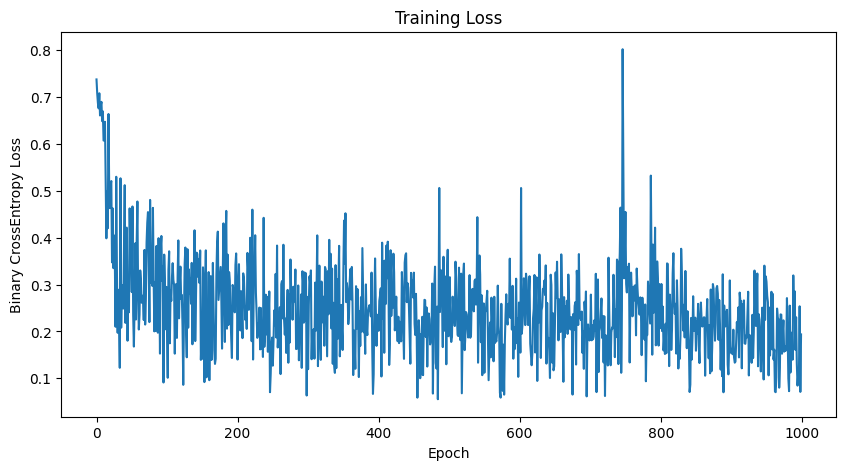

In [13]:
# Create a data loader for efficient data loading
loader = create_data_loader('weather_data.csv', batch_size=1)

# Initialize model
input_dim = 11  # Number of weather features
hidden_dim = 16
model = GNNEdgePredictor(input_dim, hidden_dim)
batch_size = 1

# Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
losses = train(model, loader, optimizer, criterion)

# plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Binary CrossEntropy Loss')
plt.title('Training Loss')
plt.show()

torch.save(model, 'GNN.pth')

# model = torch.load('model_entire.pth')

Epoch 50, Loss: 0.3988
Epoch 100, Loss: 0.4039
Epoch 150, Loss: 0.2015
Epoch 200, Loss: 0.2374
Epoch 250, Loss: 0.2211
Epoch 300, Loss: 0.0618
Epoch 350, Loss: 0.2330
Epoch 400, Loss: 0.2482
Epoch 450, Loss: 0.0994
Epoch 500, Loss: 0.1713
Epoch 550, Loss: 0.0969
Epoch 600, Loss: 0.4233
Epoch 650, Loss: 0.1519
Epoch 700, Loss: 0.1317
Epoch 750, Loss: 0.1691
Epoch 800, Loss: 0.1320
Epoch 850, Loss: 0.0123
Epoch 900, Loss: 0.0979
Epoch 950, Loss: 0.0167
Epoch 1000, Loss: 0.1547


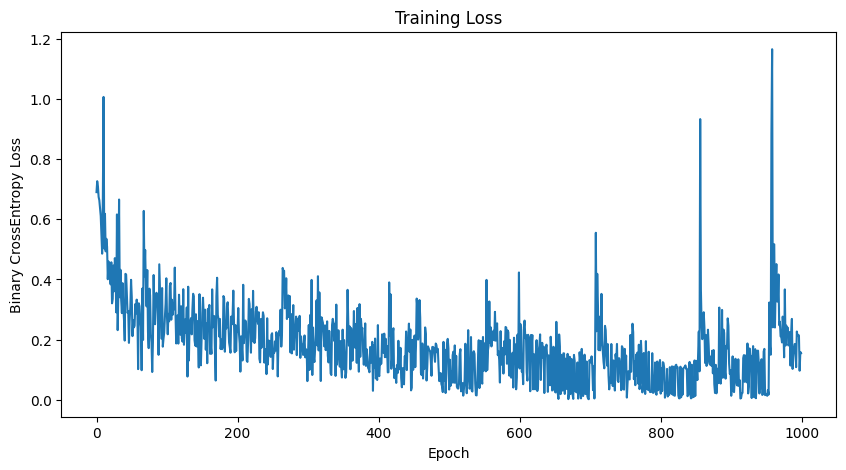

In [14]:
# Initialize model
input_dim = 11  # Number of weather features
hidden_dim = 16
c_model = CombinedGNN(input_dim, hidden_dim)
batch_size = 1

# Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(c_model.parameters(), lr=0.01)

# Train the model
losses = train(c_model, loader, optimizer, criterion)
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Binary CrossEntropy Loss')
plt.title('Training Loss')
plt.show()

# Save the model
torch.save(c_model, 'GNN_combined.pth')

# model = torch.load('model_entire.pth')

In [ ]:
# Inference example
evaluate_model(model, loader)

In [ ]:
evaluate_model(c_model, loader)

In [16]:
loader = create_data_loader('washington_jan2025.csv', batch_size=1)
# evaluate_model(model, loader)
evaluate_and_save_results(model, loader)

Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.629896  0.654663   0.646840  0.662677
1        0.6  0.651498  0.645785   0.698986  0.600109
2        0.7  0.620680  0.580707   0.699923  0.496192
3        0.8  0.603687  0.531016   0.710766  0.423830


c:\Users\eashw\Desktop\PhD_resesarch\GNN\GNN_vir_env\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Results saved to evaluation_results.csv
   Threshold  Accuracy  F1-Score  Precision    Recall
0        0.5  0.712558  0.730852   0.724599  0.737214
1        0.6  0.720622  0.727068   0.752914  0.702938
2        0.7  0.719758  0.723186   0.757901  0.691513
3        0.8  0.716302  0.716547   0.760538  0.677367


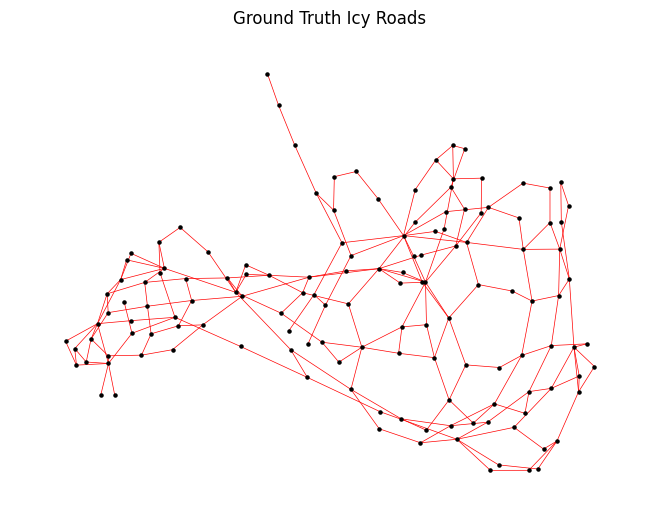

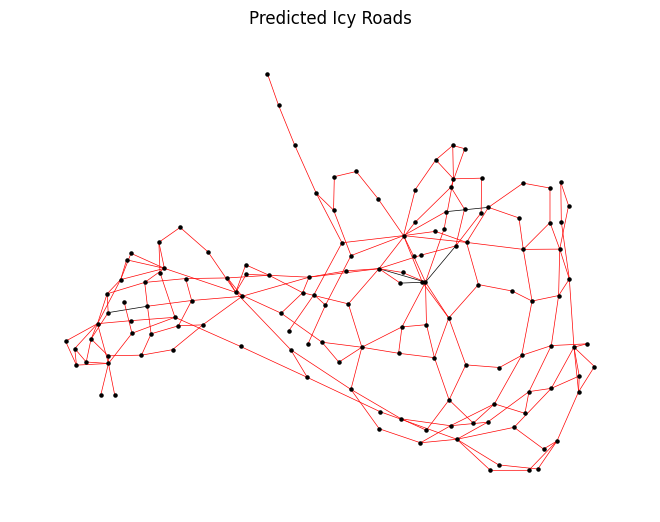

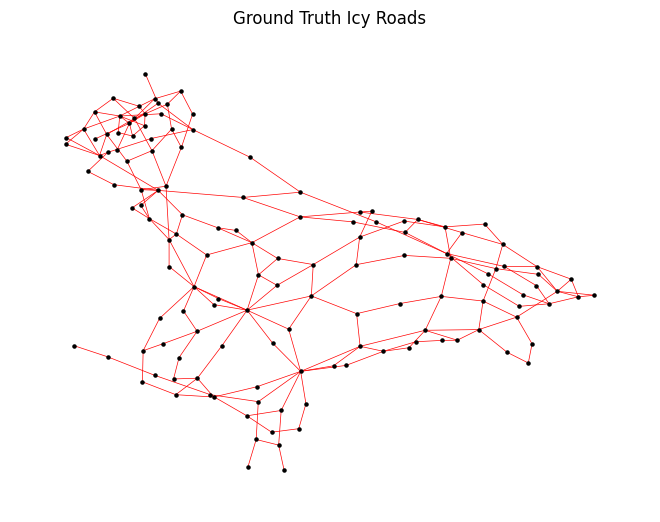

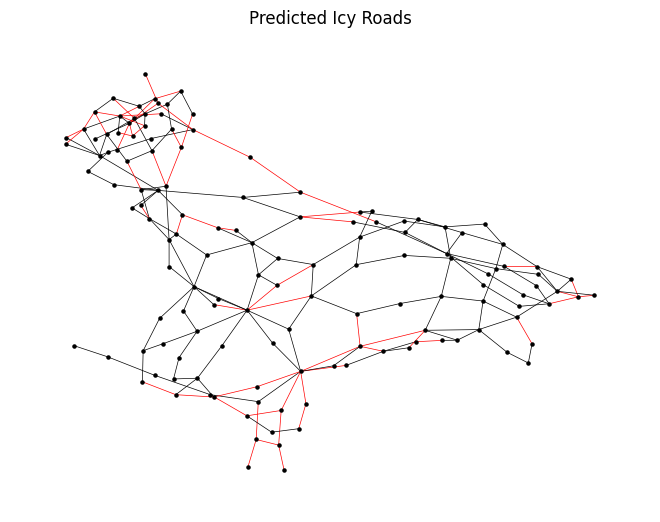

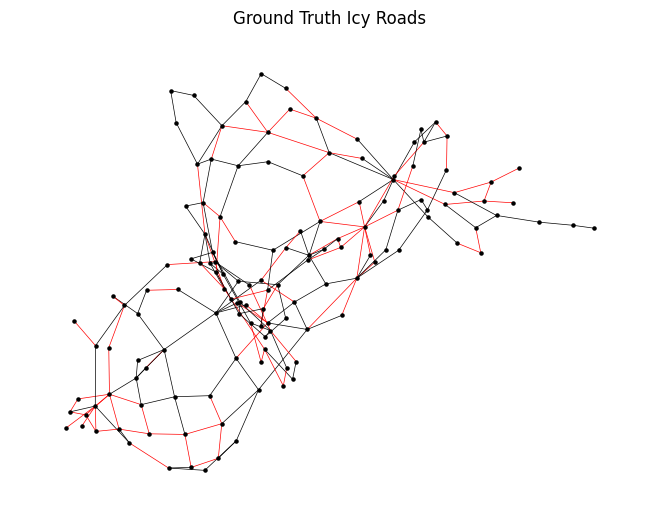

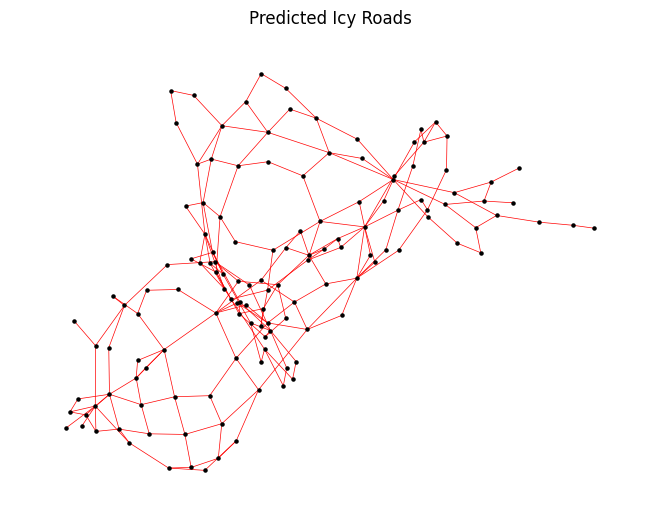

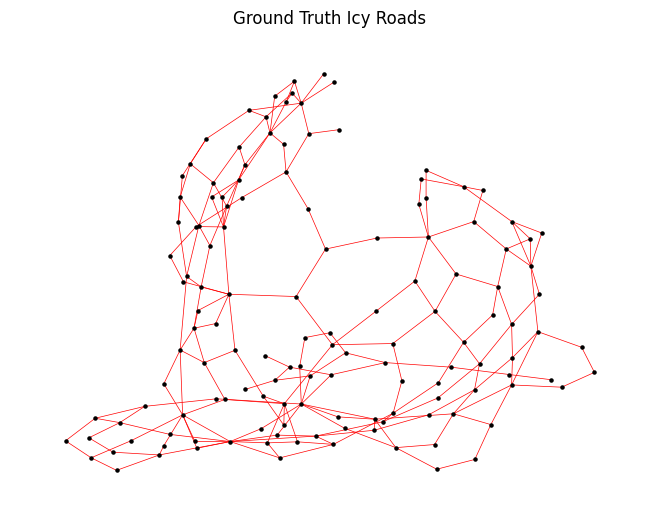

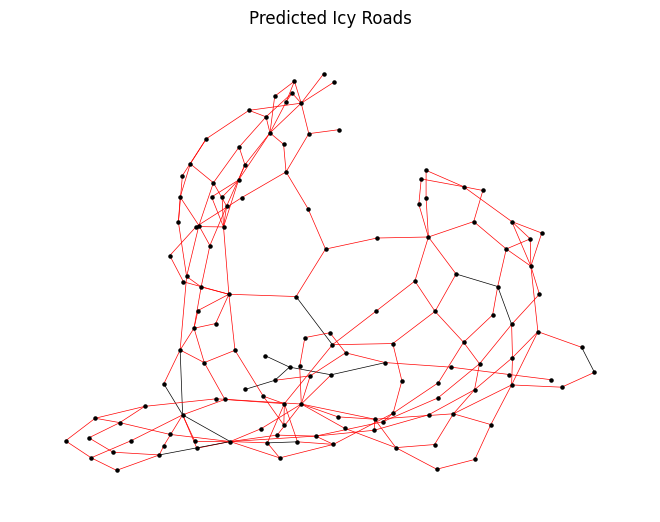

F1-score on test set (192 points, batch size 16): 0.7999
Accuracy on test set (192 points, batch size 16): 0.6665
Precision on test set (192 points, batch size 16): 0.8165
Recall on test set (192 points, batch size 16): 0.7839


In [17]:
evaluate_and_save_results(c_model, loader)
evaluate_model(c_model, loader)